# Shadow State Tomography

This notebook is modified on top of the notebook provided by https://github.com/ryanlevy/shadow-tutorial/blob/main/Tutorial_Shadow_State_Tomography.ipynb


Classical Shadow State Tomography is a technique used to reconstruct quantum states using a relatively small number of measurements. Instead of trying to measure the entire quantum state directly, which would require an enormous number of measurements for high-dimensional systems, this approach extracts a compact "shadow" of the quantum state. These shadows are later used to estimate observables efficiently. This concept is particularly useful in the context of variational quantum algorithms, quantum machine learning, and understanding many-body quantum systems.

Importing required packages

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import pdb

Measurement Basis Setup: Measurement bases are chosen randomly from a set of Pauli operators (X, Y, Z). These random measurements are crucial for building a diverse set of shadows. This is creating a list of Pauli operators that will be used for quantum state measurement in different basis

In [2]:
pauli_list = [
    np.eye(2),
    np.array([[0.0, 1.0], [1.0, 0.0]]),
    np.array([[0, -1.0j], [1.0j, 0.0]]),
    np.array([[1.0, 0.0], [0.0, -1.0]]),
]
s_to_pauli = {
    "I": pauli_list[0],
    "X": pauli_list[1],
    "Y": pauli_list[2],
    "Z": pauli_list[3],
}

# The State (i.e. Channel)

Here we'll start with the all zeros state $|0\rangle ^{\otimes n}$, apply gates to form a $n$ qubit GHZ state and perfom shadow state tomography to determine the density matrix. 

This function creates a GHZ state for upto 4 qubits. A GHZ state is a maximally entangled quantum state, often used as a benchmark for quantum entanglement experiments.

In [4]:
def channel(N,qc):
    '''create an N qubit GHZ state '''
    qc.h(0)
    if N>=2: qc.cx(0,1) # If least 2 qubits, apply a CNOT gate between qubits 0 and 1 to start creating entanglement.
    if N>=3: qc.cx(0,2) #  If there are at least 3 qubits, apply another CNOT gate between qubits 0 and 2, further entangling them
    if N>=4: qc.cx(1,3)
    if N>4: raise NotImplementedError(f"{N} not implemented!")


# This function maps a string representing a Pauli operator (X, Y, or Z) to the 
# corresponding quantum operation in Qiskit. This function does measurement in different basis.
# If measuring in "X" basis then apply a Hadamard gate.
# If measuring in Y basis then apply SDG gate
# If measuring in Z basis then pass since it is the computational basis
def bitGateMap(qc,g,qi):
    '''Map X/Y/Z string to qiskit ops'''
    if g=="X":
        qc.h(qi)
    elif g=="Y":
        qc.sdg(qi)
        qc.h(qi)
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

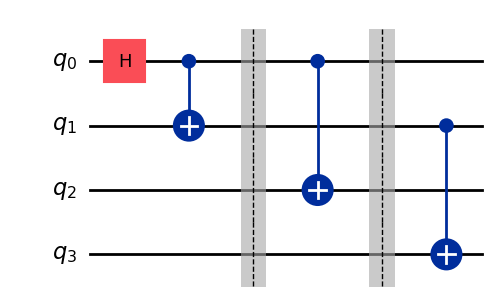

In [6]:
# GHZ state
qc = qiskit.QuantumCircuit(4)
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
qc.cx(1,3)

qc.draw(output='mpl')

    

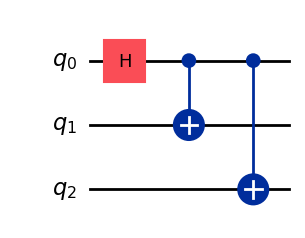

In [7]:
qc = qiskit.QuantumCircuit(3)
channel(3,qc)
qc.draw(output='mpl')

    

# Fixed $n$

Classical Shadow Procedure in bried provided here. For more details refer to the slides for Quantum Error Mitigation. 

1. Generate the state
2. Apply random rotation
3. measure bit string 
4. repeat to 1

## Clifford

Let's first do traditional state tomography. Defines the number of classical shadows to collect, i.e., 100. The number of repetitions for sampling. Here it is set to 1. Number of qubits being used, in this case, 2. 

In [21]:
nShadows = 100
reps = 1 # just one repition. Equivalent to number of shots in the run function for backends
N = 2
rng = np.random.default_rng(1717)

# Cliffords are random unitary transformations that play an important role 
# in creating diverse measurements for shadow tomography.
cliffords = [qiskit.quantum_info.random_clifford(N, seed=rng) for _ in range(nShadows)]

qc = qiskit.QuantumCircuit(N)
channel(N,qc)

# Initializes an empty list to store measurement results.
results = []

# Iterates over 100 operators
for cliff in cliffords:
    # Composes the original quantum circuit qc (which 
    # prepared the GHZ state) with a Clifford operator
    qc_c  = qc.compose(cliff.to_circuit())


    """Converts the composed quantum circuit to a statevector representation, 
    allowing simulation of the resulting quantum state. Then samples the resulting 
    quantum state reps (1) time, giving the measurement outcome"""
    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

results

[{'01': 1},
 {'11': 1},
 {'10': 1},
 {'00': 1},
 {'00': 1},
 {'01': 1},
 {'10': 1},
 {'01': 1},
 {'10': 1},
 {'11': 1},
 {'01': 1},
 {'00': 1},
 {'11': 1},
 {'11': 1},
 {'10': 1},
 {'10': 1},
 {'10': 1},
 {'10': 1},
 {'01': 1},
 {'00': 1},
 {'10': 1},
 {'00': 1},
 {'10': 1},
 {'11': 1},
 {'11': 1},
 {'10': 1},
 {'01': 1},
 {'00': 1},
 {'10': 1},
 {'01': 1},
 {'00': 1},
 {'00': 1},
 {'11': 1},
 {'00': 1},
 {'01': 1},
 {'01': 1},
 {'10': 1},
 {'10': 1},
 {'01': 1},
 {'01': 1},
 {'00': 1},
 {'11': 1},
 {'10': 1},
 {'10': 1},
 {'00': 1},
 {'11': 1},
 {'00': 1},
 {'10': 1},
 {'10': 1},
 {'11': 1},
 {'01': 1},
 {'01': 1},
 {'00': 1},
 {'00': 1},
 {'00': 1},
 {'11': 1},
 {'01': 1},
 {'00': 1},
 {'11': 1},
 {'11': 1},
 {'10': 1},
 {'11': 1},
 {'11': 1},
 {'01': 1},
 {'01': 1},
 {'01': 1},
 {'01': 1},
 {'00': 1},
 {'00': 1},
 {'11': 1},
 {'01': 1},
 {'00': 1},
 {'01': 1},
 {'01': 1},
 {'10': 1},
 {'11': 1},
 {'00': 1},
 {'10': 1},
 {'00': 1},
 {'11': 1},
 {'10': 1},
 {'11': 1},
 {'11': 1},
 {'0

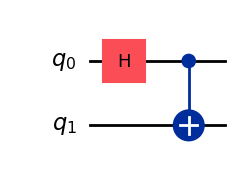

In [22]:
display(qc.draw('mpl')) # displays original circuit

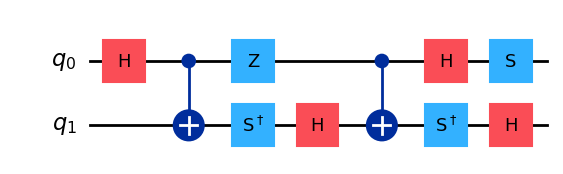

In [23]:
display(qc_c.draw('mpl'))

In [30]:
print("Length of clifford gates are: ",len(cliffords))
print("Length of the measurement results using clifford gates are: ",len(results))

list(zip(cliffords, results))

Length of clifford gates are:  100
Length of the measurement results using clifford gates are:  100


[(Clifford(array([[False,  True, False, False, False],
         [ True,  True, False, False,  True],
         [False,  True,  True,  True, False],
         [False, False,  True, False, False]])),
  {'01': 1}),
 (Clifford(array([[False,  True, False, False,  True],
         [ True, False,  True, False,  True],
         [ True,  True,  True,  True, False],
         [False,  True,  True, False,  True]])),
  {'11': 1}),
 (Clifford(array([[ True, False, False,  True, False],
         [False, False, False,  True,  True],
         [ True, False,  True,  True,  True],
         [False,  True,  True,  True, False]])),
  {'10': 1}),
 (Clifford(array([[False,  True,  True,  True, False],
         [False,  True, False,  True, False],
         [ True,  True, False,  True,  True],
         [ True,  True,  True, False,  True]])),
  {'00': 1}),
 (Clifford(array([[False,  True,  True, False,  True],
         [ True,  True,  True,  True,  True],
         [False,  True, False,  True, False],
         [Fal

Now we'll construct the shadow directly (forming a full density matrix). This will make some future post processing steps easy
$$
\hat{\rho} = \mathcal{M}^{-1}\left(U^\dagger|b\rangle\langle b|U \right) = (2^N+1)U^\dagger|b\rangle\langle b|U-I
$$

Sure! Here’s an explanation of the given equation using LaTeX:


### Explanation:

1. $(\hat{\rho})$: This is the estimated density matrix of the quantum state reconstructed using classical shadow tomography.

2. $(\mathcal{M}^{-1})$: This represents the inverse of the measurement channel, which is a part of the shadow state reconstruction process. The inverse channel is applied to adjust the measured data to estimate the actual quantum state.

3. $(U^\dagger |b\rangle \langle b| U)$:
   - $(U)$: Represents a unitary operation that is applied to the quantum state.
   - $(U^\dagger)$: The Hermitian conjugate (or adjoint) of the unitary $(U)$.
   - $(|b\rangle \langle b|)$: Represents the density operator of the state after unitary evolution and before measurement $(|b\rangle)$. Infact this is the unbiased measurement outcome.

4. **Reconstructed Form**:
   - $(2^N + 1) U^\dagger |b\rangle \langle b| U - I)$: This formula represents the reconstructed density matrix from the classical shadow measurement data.
   - $(2^N + 1)$: This term scales the projection operator to ensure that the estimation is unbiased.
   - $(I)$: The identity matrix, which is subtracted to adjust the reconstruction process.

### Summary:
The equation describes the reconstruction of the density matrix $(\hat{\rho})$ in classical shadow tomography. The idea is to apply an inverse measurement channel $(\mathcal{M}^{-1})$ to the measurement outcome $(U^\dagger |b\rangle \langle b| U)$. This inverse operation corrects the measurement biases, providing an unbiased estimate of the quantum state. The expression $(2^N + 1) U^\dagger |b\rangle \langle b| U - I$ ensures that the quantum state reconstruction takes into account the appropriate scaling and correction for all measurements.

In [38]:
shadows = []
for cliff, res in zip(cliffords, results):
    mat = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        # pdb.set_trace()
        shadows.append(Minv(N,np.outer(Ub,Ub.conj()))*count)

rho_shadow = np.sum(shadows,axis=0)/(nShadows*reps)
rho_shadow

array([[ 0.625 +3.65168667e-18j, -0.0375-3.75000000e-02j,
         0.0625-6.25000000e-02j,  0.55  +5.00000000e-02j],
       [-0.0375+3.75000000e-02j, -0.125 -4.71342408e-19j,
        -0.025 +7.50000000e-02j, -0.0125-1.25000000e-02j],
       [ 0.0625+6.25000000e-02j, -0.025 -7.50000000e-02j,
        -0.075 +1.41402722e-18j, -0.0625-8.75000000e-02j],
       [ 0.55  -5.00000000e-02j, -0.0125+1.25000000e-02j,
        -0.0625+8.75000000e-02j,  0.575 +1.76631703e-18j]])

From the given plot, you can interpret the real and imaginary parts of the density matrix for the quantum state reconstruction. 

Left Plot (Real Part): This shows the real components of the density matrix. It appears to have four highlighted elements in the corners, indicating significant values in those positions, which may correspond to coherences in the GHZ state.

Right Plot (Imaginary Part): The imaginary part of the density matrix appears to be entirely zero, which is expected for many pure states, particularly for a GHZ state. This indicates no imaginary components in this specific density matrix.

The color intensity represents the magnitude of the elements, where the brighter green areas have higher values. In this particular plot, the imaginary part is zero, while the real part shows a characteristic pattern indicating an entangled state. This pattern corresponds to the entanglement properties of the GHZ state, as there are significant coherences between specific basis states (the non-zero off-diagonal elements). The non-zero values on the corners indicate that the state is superposed with equal contributions from different computational basis states.

If these plots represent the actual density matrix and the reconstructed density matrix, you could compare these visualizations to evaluate how accurately the reconstructed state $(\rho_{shadow})$ matches the actual state $(\rho_{actual})$. Any discrepancies in the highlighted areas between the real or imaginary components would indicate deviations or errors in the shadow tomography reconstruction.

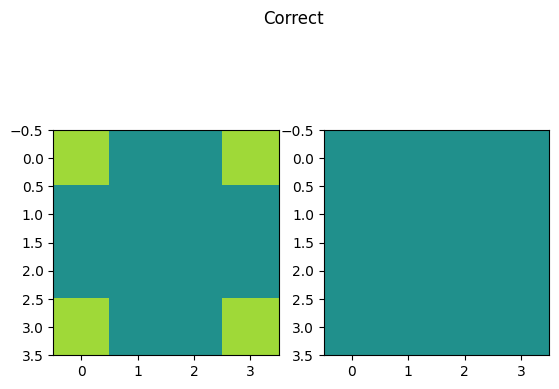

---


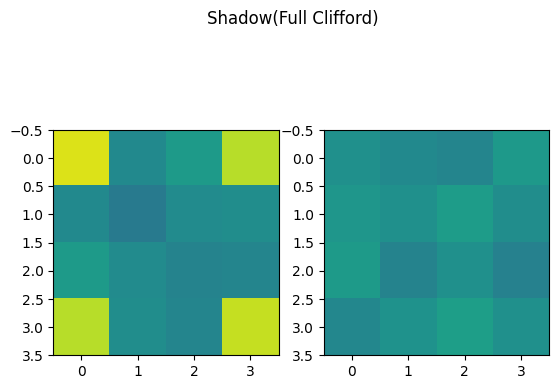

In [39]:
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)

# Extracts the real part of the density matrix.
# Sets the range of values for color scaling to make the visualization more informative.
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()

This plot consists of two 3D bar graphs, each representing the real and imaginary components of the density matrix $(\rho)$ for a quantum state:

1. **Left Plot (Real Amplitude)**: This plot shows the real part of the density matrix. The significant bars at positions (00, 00), (11, 11), and (00, 11), (11, 00) represent the major components of the GHZ state. The bars along the diagonal represent populations, while off-diagonal bars indicate coherences (quantum correlations). The heights of the bars indicate the amplitude of the real part, which is around 0.5 for each major term, typical for a maximally entangled state like GHZ.

2. **Right Plot (Imaginary Amplitude)**: This plot represents the imaginary part of the density matrix. There are minimal to no bars with height, which indicates that there are no significant imaginary components in this state. This is expected for a pure GHZ state, as it often has real amplitudes without imaginary contributions.

### Interpretation:
- The **GHZ state** is represented by the two major components $(|00\rangle)$ and $(|11\rangle)$, each with equal real amplitude, which indicates the superposition of these states.
- The absence of any significant imaginary component suggests that the state is predominantly real, which aligns with what we expect for an ideal GHZ state.
- This visualization helps to understand how the quantum state’s amplitudes are distributed in the computational basis, and the significant off-diagonal real components confirm entanglement between the qubits.

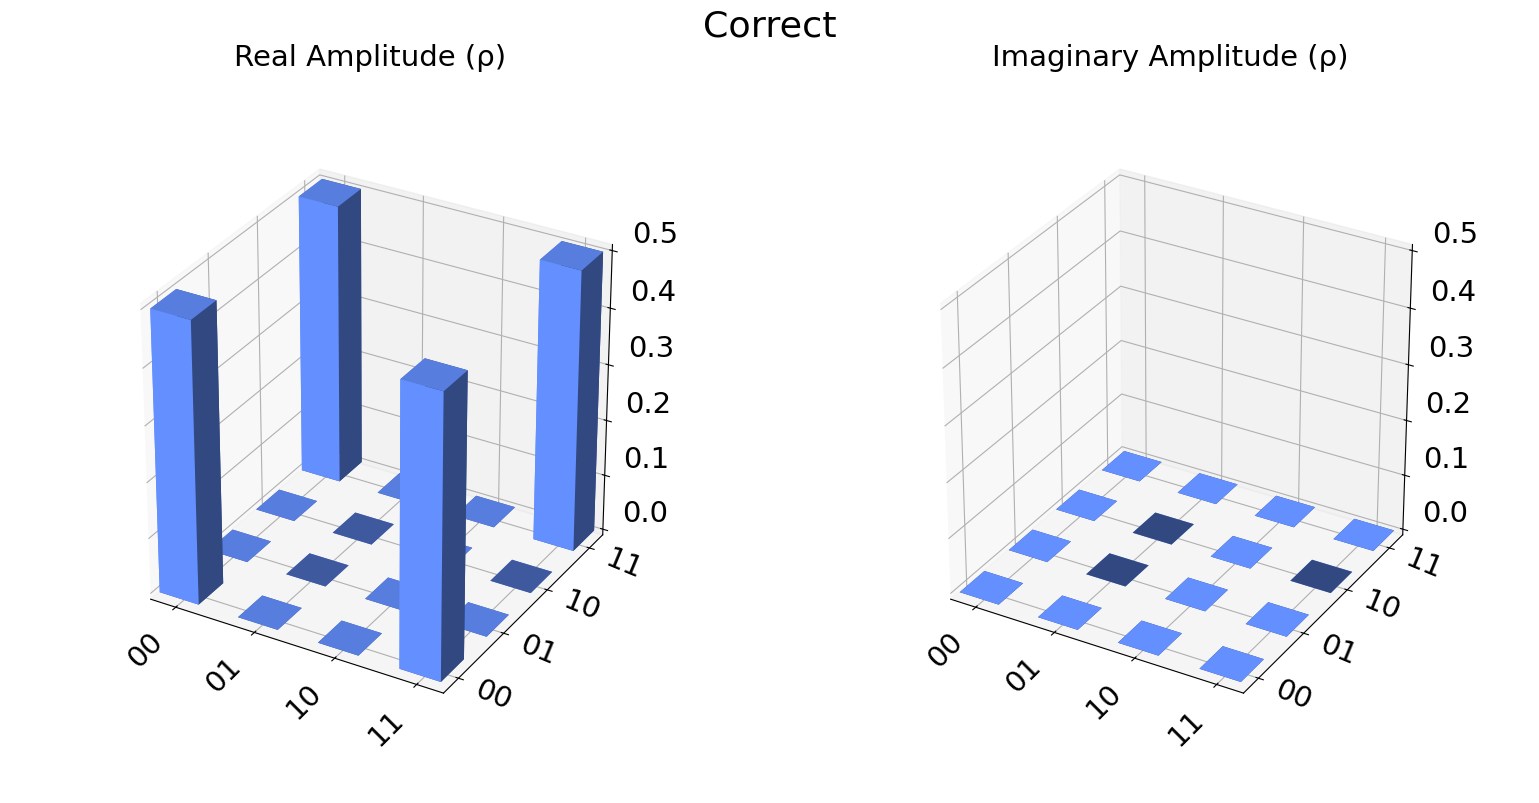

In [40]:
qiskit.visualization.state_visualization.plot_state_city(rho_actual,title="Correct")


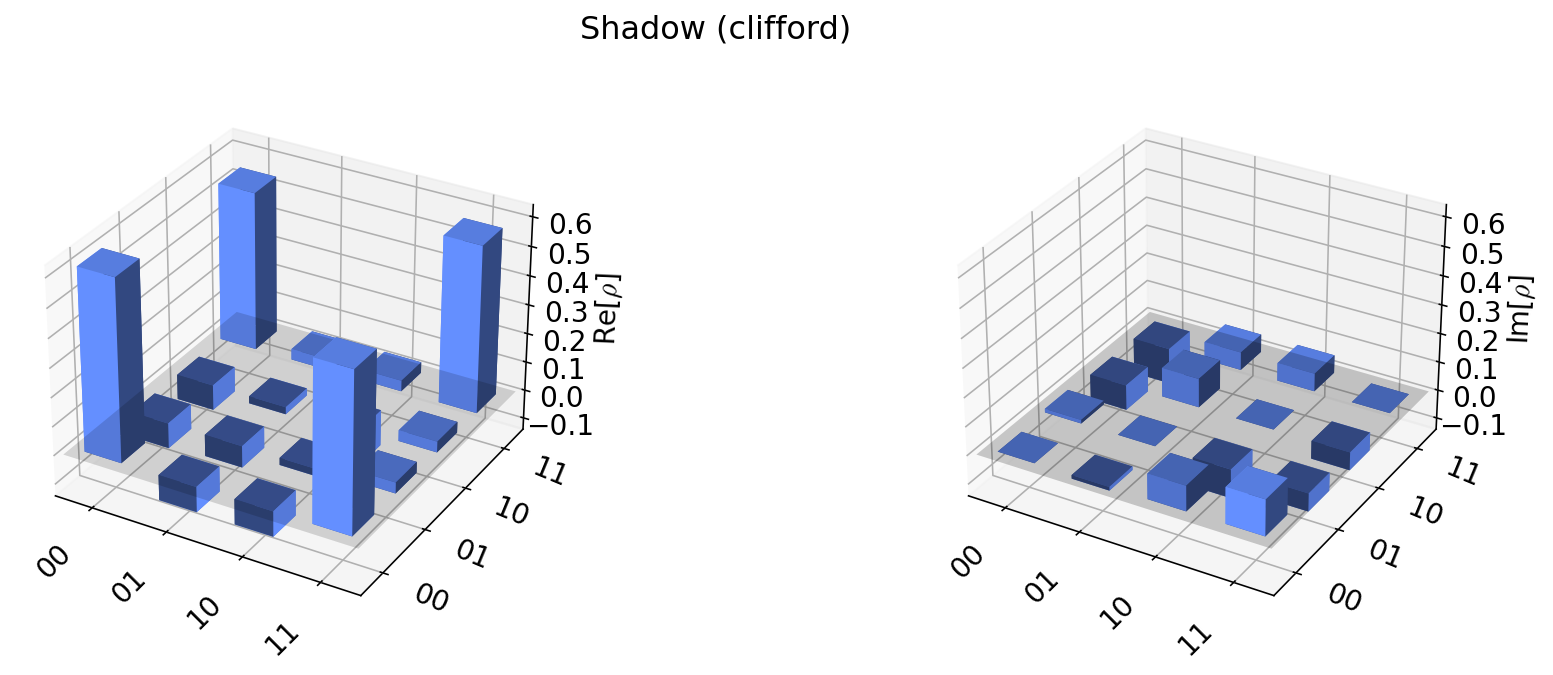

In [12]:
qiskit.visualization.state_visualization.plot_state_city(rho_shadow,title="Shadow (clifford)")


## Pauli

Repeating the above, but now with a Pauli string. Note this is effectively the same as single qubit Cliffords

In [13]:
nShadows = 10_000
N = 2

rng = np.random.default_rng(1717)
scheme = [rng.choice(['X','Y','Z'],size=N) for _ in range(nShadows)]
labels, counts = np.unique(scheme,axis=0,return_counts=True)
    
qc = qiskit.QuantumCircuit(N)
channel(N,qc)

results = []
for bit_string,count in zip(labels,counts):
    qc_m = qc.copy() 
    # rotate the basis for each qubit
    for i,bit in enumerate(bit_string): bitGateMap(qc_m,bit,i) 
    counts = qiskit.quantum_info.Statevector(qc_m).sample_counts(count)
    results.append(counts)

Note: qiskit using little-endian encoding so $X_1|00\rangle = |10\rangle$

In [14]:
def rotGate(g):
    '''produces gate U such that U|psi> is in Pauli basis g'''
    if g=="X":
        return 1/np.sqrt(2)*np.array([[1.,1.],[1.,-1.]])
    elif g=="Y":
        return 1/np.sqrt(2)*np.array([[1.,-1.0j],[1.,1.j]])
    elif g=="Z":
        return np.eye(2)
    else:
        raise NotImplementedError(f"Unknown gate {g}")       

In [15]:
shadows = []
shots = 0
for pauli_string,counts in zip(labels,results):
    # iterate over measurements
     for bit,count in counts.items():
        mat = 1.
        for i,bi in enumerate(bit[::-1]):
            b = rotGate(pauli_string[i])[int(bi),:]
            mat = np.kron(Minv(1,np.outer(b.conj(),b)),mat)
        shadows.append(mat*count)
        shots+=count

rho_shadow = np.sum(shadows,axis=0)/(shots)

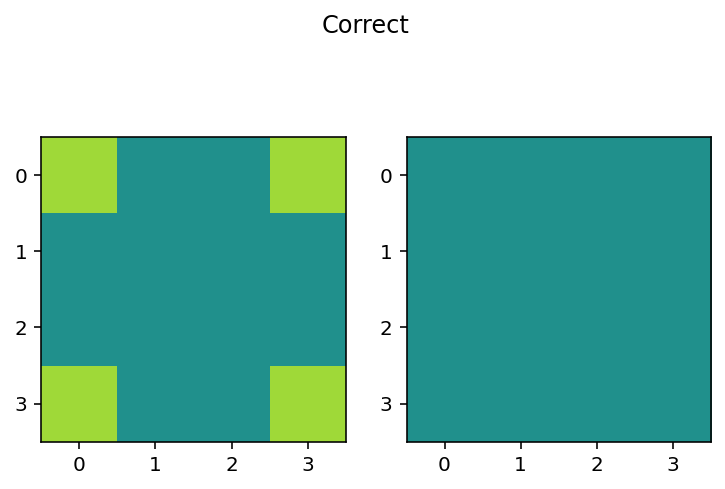

---


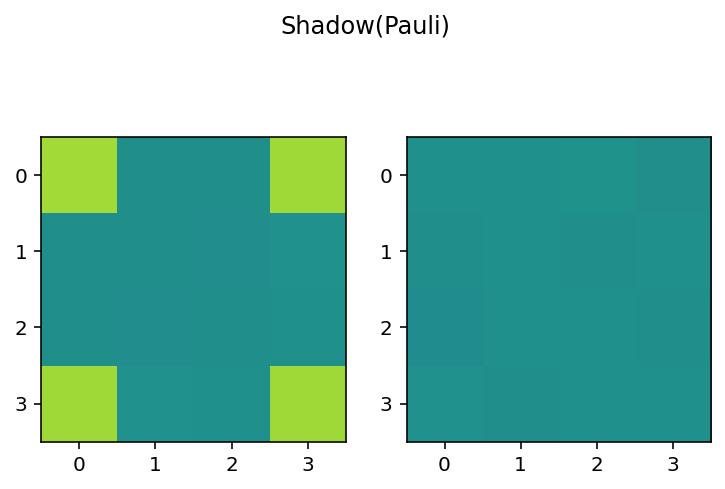

In [16]:
rho_actual = qiskit.quantum_info.DensityMatrix(qc).data


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(rho_actual.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_actual.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Pauli)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()